# Binary Search With Tunable Ratio

In [ ]:
import numpy as np
import optuna
import random
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from optuna.visualization import plot_contour
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

def binary_search_with_ratio(arr, target, ratio):
    """
    arr: sorted list
    target: value to find
    ratio: hyperparameter in (0, 1), controls where we split the interval
    Returns: (found, num_comparisons)
    """
    low = 0
    high = len(arr) - 1
    comparisons = 0

    # Safety: keep ratio away from exactly 0 or 1
    ratio = max(0.01, min(0.99, ratio))

    while low <= high:
        # Compute mid using the ratio
        mid = low + int((high - low) * ratio)
        mid = max(low, min(mid, high))

        comparisons += 1
        if arr[mid] == target:
            return True, comparisons
        elif arr[mid] < target:
            low = mid + 1
        else:
            high = mid - 1

    return False, comparisons


C:\Users\JTSoundy1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Generation

In [2]:
ListSize = 1024
list_of_natural_numbers = list(range(ListSize))

def uniform_targets(num_trials):
    u = random.random()
    uniform_targets = list()
    for _ in range(num_trials):
        uniform_targets.append(random.randint(0, ListSize - 1))
    return uniform_targets

def skewed_targets(num_trials):
    u = random.random()
    skewed_targets = list()
    for _ in range(num_trials):
        if u < 0.9:
            # 90% of the time, pick from first quarter
            skewed_targets.append(random.randint(0, ListSize // 4 - 1))
        else:
            # 10% of the time, pick from remaining 3/4
            skewed_targets.append(random.randint(ListSize // 4, ListSize - 1))
    return skewed_targets



# Objective Function

In [3]:
def average_comparisons_for_ratio(ratio, trials):
    total_comparisons = 0
    for target in trials:
        found, comps = binary_search_with_ratio(list_of_natural_numbers, target, ratio)
        total_comparisons += comps
    return total_comparisons / len(trials)

# Quick test for a couple of ratios
test_trials_uniform = uniform_targets(1000)
test_trials_skewed = skewed_targets(1000)
for r in [0.3, 0.5, 0.7]:
    u_avg = average_comparisons_for_ratio(r, test_trials_uniform)
    s_avg = average_comparisons_for_ratio(r, test_trials_skewed)
    print(f"Ratio={r:.2f}, uniform avg comparisons={u_avg:.3f}, skewed avg comparisons={s_avg:.3f}")


Ratio=0.30, uniform avg comparisons=10.423, skewed avg comparisons=8.908
Ratio=0.50, uniform avg comparisons=8.996, skewed avg comparisons=9.017
Ratio=0.70, uniform avg comparisons=9.843, skewed avg comparisons=11.697


# Visualize the Hidden Function

Best ratio from grid search ≈ 0.359, avg comps=8.604


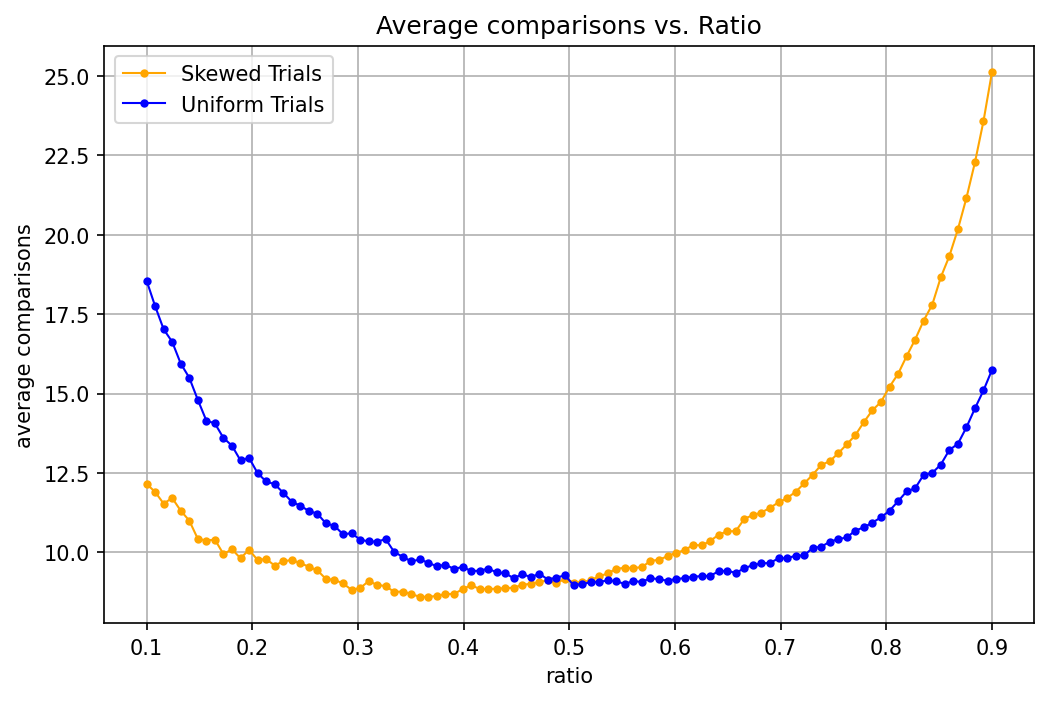

In [4]:
ratios = np.linspace(0.1, 0.9, 100)
grid_num_trials = len(ratios)
uniform_avg_comps = [average_comparisons_for_ratio(r, test_trials_uniform) for r in ratios]
skewed_avg_comps = [average_comparisons_for_ratio(r, test_trials_skewed) for r in ratios]

plt.figure(figsize=(8, 5), dpi=150)
plt.plot(ratios, skewed_avg_comps, marker='o',markersize=3, linewidth=1, color = 'orange', label='Skewed Trials')
plt.plot(ratios, uniform_avg_comps, marker='o',markersize=3, linewidth=1, color = 'blue', label='Uniform Trials')
plt.xlabel("ratio")
plt.ylabel("average comparisons")
plt.title("Average comparisons vs. Ratio")
plt.legend()
plt.grid(True)

best_idx = int(np.argmin(skewed_avg_comps))
print(f"Best ratio from grid search ≈ {ratios[best_idx]:.3f}, avg comps={skewed_avg_comps[best_idx]:.3f}")


# Hyper Parameter Tune with Bayesian Optimization

In [5]:
def objective(trial):
    # Sample ratio in (0.1, 0.9) to avoid edge pathologies
    ratio = trial.suggest_float("ratio", 0.1, 0.9)
    avg_comp = average_comparisons_for_ratio(ratio, test_trials_skewed)
    return avg_comp  # we want to minimize this

study = optuna.create_study(direction="minimize")
optuna_num_trials = 30
study.optimize(objective, n_trials=optuna_num_trials)  # you can increase this later



[I 2025-11-20 11:32:16,938] A new study created in memory with name: no-name-277dd9b3-ace1-4f50-98d6-2750e40f2fd4
[I 2025-11-20 11:32:16,940] Trial 0 finished with value: 10.303 and parameters: {'ratio': 0.6351779115120175}. Best is trial 0 with value: 10.303.
[I 2025-11-20 11:32:16,942] Trial 1 finished with value: 8.817 and parameters: {'ratio': 0.29496723791642143}. Best is trial 1 with value: 8.817.
[I 2025-11-20 11:32:16,944] Trial 2 finished with value: 9.001 and parameters: {'ratio': 0.47285715918146287}. Best is trial 1 with value: 8.817.
[I 2025-11-20 11:32:16,945] Trial 3 finished with value: 9.069 and parameters: {'ratio': 0.2744623854395831}. Best is trial 1 with value: 8.817.
[I 2025-11-20 11:32:16,947] Trial 4 finished with value: 8.794 and parameters: {'ratio': 0.3886507032385037}. Best is trial 4 with value: 8.794.
[I 2025-11-20 11:32:16,949] Trial 5 finished with value: 9.667 and parameters: {'ratio': 0.24615492437410672}. Best is trial 4 with value: 8.794.
[I 2025-11-

# Step by Step Walkthrough of What Optuna is Doing

In [ ]:
# Domain for the ratio hyperparameter
bounds = (0.1, 0.9)
X_grid = np.linspace(bounds[0], bounds[1], 200).reshape(-1, 1)

# True objective for visualization (deterministic because trials list is fixed)
y_true = np.array([
    average_comparisons_for_ratio(float(x), test_trials_skewed)
    for x in X_grid.ravel()
])

df = study.trials_dataframe(attrs=("number", "value", "params", "state"))

# Keep only completed trials
df = df[df["state"] == "COMPLETE"].reset_index(drop=True)

# Adjust this column name if your parameter isn't exactly 'ratio'
X_all = df["params_ratio"].to_numpy().reshape(-1, 1)
y_all = df["value"].to_numpy()

df.head()

kernel = 1.0 * RBF(length_scale=0.2) + WhiteKernel(noise_level=1.0)

def build_gp(X_sample, y_sample):
    gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True
    )
    gp.fit(X_sample, y_sample)
    return gp

def plot_state(X_sample, y_sample, gp=None, title=""):
    plt.figure(figsize=(8, 5))

    # True objective
    plt.plot(X_grid, y_true, label="True objective", linewidth=2)

    # Surrogate model
    if gp is not None and len(X_sample) > 0:
        mu, std = gp.predict(X_grid, return_std=True)
        plt.plot(X_grid, mu, linestyle="--", label="Surrogate mean")
        plt.fill_between(
            X_grid.ravel(),
            mu - 1.96 * std,
            mu + 1.96 * std,
            alpha=0.2,
            label="Uncertainty (±1.96σ)",
        )

    # Sampled points so far
    if len(X_sample) > 0:
        plt.scatter(X_sample, y_sample, zorder=5, label="Samples so far")

    plt.xlabel("ratio")
    plt.ylabel("avg comparisons")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


,number,value,params_ratio,state
0,0,10.303,0.635178,COMPLETE
1,1,8.817,0.294967,COMPLETE
2,2,9.001,0.472857,COMPLETE
3,3,9.069,0.274462,COMPLETE
4,4,8.794,0.388651,COMPLETE


# Visualize Optuna's Process

In [7]:
fig = plot_optimization_history(study)
fig.show()
plot_param_importances(study).show()
plot_slice(study).show()
plot_contour(study).show()

# Final Results

In [8]:

best_trial = study.best_trial
optuna_best_ratio = best_trial.params["ratio"]
grid_best_ratio = ratios[best_idx]


rows = [
    ["Midpoint (0.5)",
     "-", 
     f"{average_comparisons_for_ratio(0.5, test_trials_skewed):.3f}",
     "-"],

    ["Optuna",
     f"{optuna_best_ratio:.3f}",
     f"{average_comparisons_for_ratio(optuna_best_ratio, test_trials_skewed):.3f}",
     optuna_num_trials],

    ["Grid Search",
     f"{grid_best_ratio:.3f}",
     f"{average_comparisons_for_ratio(grid_best_ratio, test_trials_skewed):.3f}",
     grid_num_trials],
]

print(tabulate(
    rows,
    headers=["Method", "Best Ratio", "Avg Comparisons", "Trials"],
    tablefmt="github"
))

| Method         | Best Ratio   |   Avg Comparisons | Trials   |
|----------------|--------------|-------------------|----------|
| Midpoint (0.5) | -            |             9.017 | -        |
| Optuna         | 0.368        |             8.586 | 30       |
| Grid Search    | 0.359        |             8.604 | 100      |
